![](https://scholar.harvard.edu/files/a-y/files/web-banda.png)

# A gentle introduction to diffusion MRI

This tutorial gives an overview of diffusion MRI (dMRI) data, and the basic steps involved in analyzing such data prior to reconstructing white-matter fiber bundles, like the ones shown in the image above. The goal is to gain familiarity with the data, as well as with the key image processing steps.

First, let's import all the necessary packages:


In [2]:

pkglist = ["Downloads", "Plots", "Interact", "WebIO", "Statistics", "LaTeXStrings"];

using Pkg
Pkg.add.(pkglist)
Pkg.add(url="https://github.com/freesurfer/FreeSurfer.jl")

using Downloads, Plots, Interact, WebIO, Statistics, LaTeXStrings, FreeSurfer


   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
    Updating git-repo `https://github.com/freesurfer/FreeSurfer.jl`
   Resol

Now let's download the data to the current directory:

In [3]:

indir = "/cluster/pubftp/data/dmri.tutorial"

if !isdir(indir) # Remote user
  indir = "./tutorial"

  if !isfile(indir * "/dwi_orig.nii.gz")
    tarfile = Downloads.download("https://surfer.nmr.mgh.harvard.edu/pub/data/dmri.tutorial.tar.gz");
    cmd = `tar xzvf $tarfile`
    run(cmd)
  end
end


## Exploring the data

A dMRI scan consists of a series of diffusion-weighted images (DWIs). Each DWI contains information on the diffusion of water molecules in a specific direction, at every voxel in the brain. When all the DWIs are put together, they make up a 4D dataset, where each each 3D volume is a different DWI. Let's start by loading such a dataset:

In [ ]:

dwi = mri_read(indir * "/dwi.nii.gz");



Let's look at some basic information on the dataset that we just loaded:


In [4]:

info(dwi)


Read from: ./tutorial/dwi.nii.gz
Volume dimensions: [140, 140, 92, 198]
Spatial resolution: [1.5, 1.5, 1.5]
b-values: [5.0, 1490.0, 2990.0, 1495.0, 3005.0, 1500.0, 2985.0, 2995.0, 3000.0, 2980.0, 1505.0, 3010.0]
Intensity range: [-2183.135986328125, 42356.80078125]



This scan was collected as part of the Human Connectome Project at MGH (protocol details have been [described elsewhere](https://pubmed.ncbi.nlm.nih.gov/32339824/)). It includes 198 DWI volumes and each volume has dimensions 140 $\times$ 140 $\times$ 92 voxels. The voxel size is 1.5mm isotropic. Every volume is associated with a number called the $b$-value. We'll see what this means later. For now, we know that the DWIs in this dataset were collected either with $b$-values roughly ranging from 5 to 3000. Let's look at these images more closely:


In [8]:

@manipulate throttle=.1 for slice=1:5:92, volume=slider(1:198, value=1, label="volume")
  show(dwi, plane='a', z=slice, t=volume)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 19, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
10, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9906eb2ca0, Task (runnable) @0x00007f9906eb2ca0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"6\",\"11\",\"16\",\"21\",\"26\",\"31\",\"36\",\"41\",\"46\",\"51\",\"56\",\"61\",\"66\",\"71\",\"76\",\"81\",\"86\",\"91\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"6299772376558617398\",\"id\":\"10904885291452288530\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"sc

We can see that some volumes in the DWI series are darker and others are brighter. We also see that there are two items associated with each volume, which are displayed at the top left corner. One is the $b$-value, and the other is $\bf{g}$, the diffusion-encoding gradient direction. Both of these are acquisition parameters, and both of them affect the contrast in the images.

Let's look at the b-value that was used to acquire each the images in this DWI series:

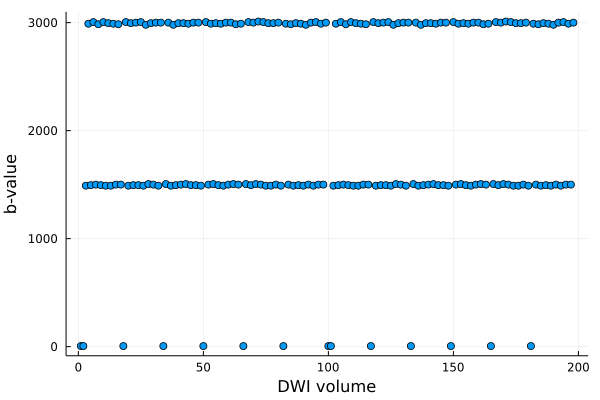

In [9]:

scatter(1:length(dwi.bval), dwi.bval, legend=false, xlab="DWI volume", ylab="b-value")


We have a few volumes acquired with approximately $b$=0, among many more volumes acquired with $b$=1500 or 3000. (Although technically they are acquired with $b$=5, we will refer to these as "$b$=0 volumes", as they are virtually indistiguishable from volumes acquired with $b$=0.) There are far fewer of these $b$=0 volumes because they are not that interesting &mdash; they look the same regardless of gradient direction. However we need at least one $b$=0 volume, to serve as the reference signal to which the higher-$b$ volumes will be compared to. We often acquire more than one, to increase signal-to-noise ratio. We also often acquire them interspersed between the other volumes, to aid with motion correction.

Now let's look at the gradient vectors that were used to acquire the DWIs in this dataset:

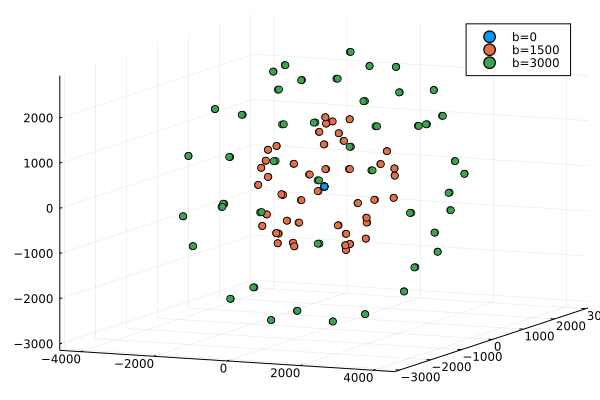

In [10]:

g = dwi.bval .* dwi.bvec

i_b0 = isapprox.(dwi.bval, 0; atol=20)
scatter(g[i_b0, 1], g[i_b0, 2], g[i_b0, 3], label="b=0", aspect_ratio=:equal)

i_b1 = isapprox.(dwi.bval, 1500; atol=20)
scatter!(g[i_b1, 1], g[i_b1, 2], g[i_b1, 3], label="b=1500")

i_b2 = isapprox.(dwi.bval, 3000; atol=20)
scatter!(g[i_b2, 1], g[i_b2, 2], g[i_b2, 3], label="b=3000")


Each dot represents a volume in the DWI series, and the color of the dot represents the $b$-value for the same volume. The vectors are roughly uniformly distributed over a sphere for each $b$-value. This why we'd say that these data were acquired on *shells*. The $b$=0 data do not count as a shell, so here we'd say that the data were collected on 2 shells: $b$=1500 and $b$=3000.

The effect of the b-value is easy to figure out by looking at the images: the higher the b-value, the lower the DWI signal. We can appreciate this further by plotting the image values of each voxel as a time course:

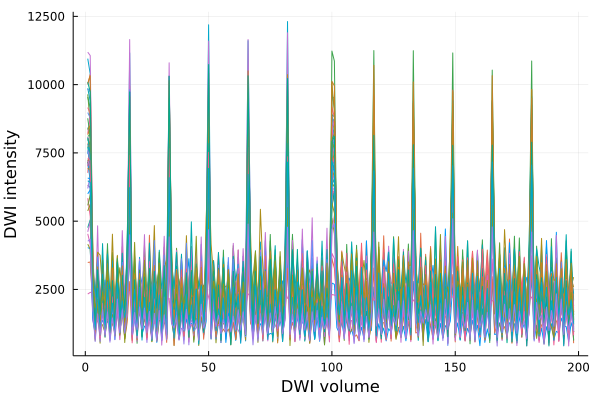

In [11]:

# Arrange DWI volumes as a matrix, where each row is a voxel and each column a volume
dwi_mat = reshape(dwi.vol, prod(dwi.volsize), :)

# Pick a few voxels where the signal is not zero
dwi_mat = dwi_mat[vec(all(dwi_mat .> 0.01*maximum(dwi_mat), dims=2)), :]
dwi_mat = dwi_mat[1:1000:end, :]

# Plot as one "time course" for each voxel
plot(dwi_mat', legend = false, xlab="DWI volume", ylab="DWI intensity")


Each line represents a different voxel. Those "time points" where the signal in all voxels is high are the low-$b$ (a.k.a., $b$=0) data points. The ones where the signal in all voxels in low are the high-$b$ (a.k.a., $b$=1500 or 3000) data points. So the b-value controls the contrast (makes the image "darker") &mdash; and we control the $b$-value (when we set up the scan protocol).

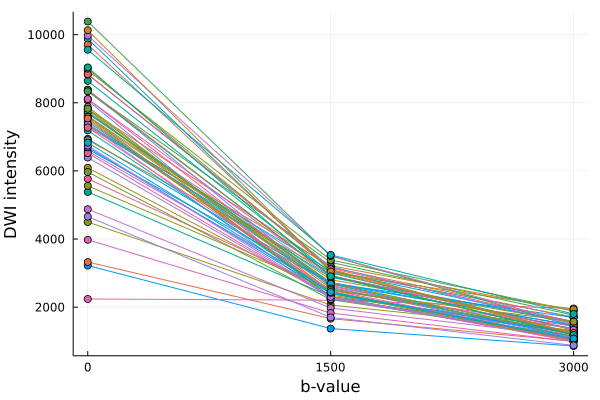

In [12]:

# For each voxel, find the average DWI signal at each b-value
dwi_b0 = mean(dwi_mat[:,i_b0], dims=2)
dwi_b1 = mean(dwi_mat[:,i_b1], dims=2)
dwi_b2 = mean(dwi_mat[:,i_b2], dims=2)

# Plot average DWI signal vs. b-value for each voxel
plot([fill(0, size(dwi_b0'));
      fill(1500, size(dwi_b1'));
      fill(3000, size(dwi_b2'))], [dwi_b0'; dwi_b1'; dwi_b2'], 
     marker=:circle, legend=false, xlab="b-value", ylab="DWI intensity", xticks=[0, 1500, 3000])


Again, each line is a different voxel. You'll notice that, for all voxels, the signal decays as the $b$-value increases. However, this signal decay is more dramatic for some voxels than for others. That's because the signal decay depends not only on the $b$-value, but also on an intrinsic property of the tissue, called the *diffusivity*. Voxels where there are fewer barriers to the movements of water molecules have higher diffusivity, and exhibit a faster decay of the DWI signal as the $b$-value increases.

You'll also notice that the signal seems to decay exponentially as the $b$-value increases. Importantly, we can only tell this is the case because we have 3 $b$-values. If we had only 2 $b$-values, we might've thought that the signal decays linearly. This is a hint that *multi-shell* data allow some modeling beyond what is possible with *single-shell* data.

## Apparent diffusion coefficient
We can confirm that the variability across voxels that we see in the figure above is not random, but has to do with the tissue type, by loading an anatomical segmentation of this subject (this will also come in handy later as a brain mask): 

In [13]:

aa = mri_read(indir * "/aparc+aseg.bbr.nii.gz");


This segmentation was generated by running FreeSurfer on the $T_1$-weighted scan of this subject, and was then aligned to the subject's DWIs. The $T_1$-to-DWI alignment was performed with [boundary-based registration](https://surfer.nmr.mgh.harvard.edu/fswiki/bbregister) in FreeSurfer ([Greve and Fischl, 2008](https://pubmed.ncbi.nlm.nih.gov/19573611/)). 

Let's look at some basic information on the segmentation volume that we just loaded:

In [14]:

info(aa)


Read from: ./tutorial/aparc+aseg.bbr.nii.gz
Volume dimensions: [140, 140, 92, 1]
Spatial resolution: [1.5, 1.5, 1.5]
Intensity range: [0.0, 2035.0]



This confirms that the segmentation has been co-registered to the DWIs: it has the same spatial resolution (1.5mm isotropic) and the same volume dimensions (140 $\times$ 140 $\times$ 96 voxels). Let's look at it:


In [15]:

@manipulate throttle=.01 for slice=1:96
  show(aa, plane='a', z=slice)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 96, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
48, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9907d63820, Task (runnable) @0x00007f9907d63820), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

Now that we've loaded a segmentation, we can look at how the DWI signal behaves in white matter vs. gray matter vs. CSF. Let's first find voxels from each tissue class in the FreeSurfer segmentation:

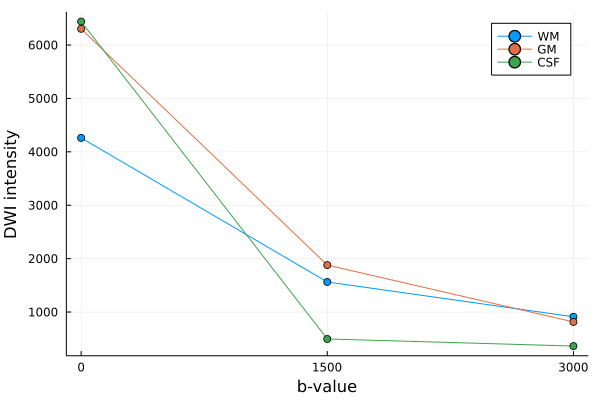

In [17]:

# Find white-matter voxels in the anatomical segmentation
seg_wm = color_lut.id[contains.(color_lut.name, "-Cerebral-White-Matter")]

i_wm = findall(in(seg_wm).(vec(aa.vol)))

# Find cortical gray-matter voxels in the anatomical segmentation
i_gm = findall(1000 .<= vec(aa.vol) .< 3000)

# Find ventricle voxels in the anatomical segmentation 
seg_csf = color_lut.id[contains.(color_lut.name, "-Ventricle")]
i_csf = findall(in(seg_csf).(vec(aa.vol)));

# Arrange DWI volumes as a matrix, where each row is a voxel and each column a volume
dwi_mat = reshape(dwi.vol, prod(dwi.volsize), :)

# Average DWIs over voxels in each tissue class, and volumes acquired with each b-value
dwi_wm  = [mean(dwi_mat[i_wm, i_b0])
           mean(dwi_mat[i_wm, i_b1])
           mean(dwi_mat[i_wm, i_b2])]
dwi_gm  = [mean(dwi_mat[i_gm, i_b0])
           mean(dwi_mat[i_gm, i_b1])
           mean(dwi_mat[i_gm, i_b2])]
dwi_csf = [mean(dwi_mat[i_csf, i_b0])
           mean(dwi_mat[i_csf, i_b1])
           mean(dwi_mat[i_csf, i_b2])]

# Plot average DWI signal vs. b-value for each tissue class
plot([0; 1500; 3000], [dwi_wm dwi_gm dwi_csf], 
     marker=:circle, label=["WM" "GM" "CSF"], xlab="b-value", ylab="DWI intensity", xticks=[0, 1500, 3000])


Based on how fast the DWI signal drops in each type of tissue as the $b$-value increases, we expect CSF to have the highest diffusivity, followed by gray and than white matter.

We will now estimate the diffusivity. The typical assumption is that the DWI signal $s$ decreases exponentially as the $b$-value of the acquisition or the diffusivity $d$ of the tissue increases:

$ s(b) = s(0) \cdot e^{-b \cdot d} $

The only unknown in this equation is $d$. (We know all the other quantities &mdash; in fact we used them to make the plot above!) This means that we can estimate $d$ in every voxel by fitting this exponential model. 

We will exclude the $b$=3000 data from this fitting. This is done because for $b$-values higher than about 2000, the signal actually violates the simple, mono-exponential model above. Let's generate a separate DWI series that includes only the $b$=0 and $b$=1500 volumes:

In [18]:

ivol = (dwi.bval .< 2000)

dwi_1500 = MRI(dwi, sum(ivol))

dwi_1500.vol  = dwi.vol[:, :, :, ivol]
dwi_1500.bval = dwi.bval[ivol]
dwi_1500.bvec = dwi.bvec[ivol, :];


Now let's perform the fitting using this lower shell only:

In [19]:

adc, s0 = adc_fit(dwi_1500, aa);


Note that, in the fitting above, we used the anatomical segmentation as a brain mask. Let's look at the diffusivity, which is sometimes also referred to as the *apparent diffusion coefficient* (ADC):

In [20]:

@manipulate throttle=.01 for slice=1:96
  show(adc, plane='a', z=slice)
  plot!(;colorbar=:right)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 96, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
48, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9901c4af80, Task (runnable) @0x00007f9901c4af80), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

This confirms that the diffusivity is much higher in the CSF than in the white or gray matter. Let's check its average value in the ventricles:

In [21]:

println("Ventricles: " * string(mean(adc.vol[i_csf])))
println("Cortical gray matter: " * string(mean(adc.vol[i_gm])))
println("White matter: " * string(mean(adc.vol[i_wm])))


Ventricles: 0.0018178048
Cortical gray matter: 0.00082864607
White matter: 0.0007018848


These values become important in some modern methods for reconstructing fiber orientations, which attempt to tease apart isotropic (gray matter and CSF) from anisotropic (white matter) components of the DWI signal in each voxel. Such methods rely on assumptions of typical diffusivity values in each tissue type. If there is a concern that these assumptions may not apply to your data/subjects, this is how you can check.

## Tensors
The calculation of the ADC does not require the gradient vectors, as the ADC is the average diffusivity over all directions. However, the dependence of the diffusivity on the direction is particularly important for tractography. Diffusivity is greater parallel than perpendicular to a fiber bundle. The fact that we have collected data with multiple diffusion-encoding directions will allow us to detect this and hence to infer the orientation of axon bundles.

The simplest model that we can use to make such an inference is the diffusion tensor:

$ s(b) = s(0) \cdot e^{-b \cdot \bf{g}' \cdot \bf{D} \cdot \bf{g} } $

Here, instead of a scalar diffusivity $d$, we have $\bf{g}' \cdot \bf{D} \cdot \bf{g}$, where $\bf{g}$ the diffusion-encoding gradient vector used to acquire the DWI and $\bf{D}$ is the tensor, which is a 3$\times$3 symmetric matrix.

It can be decomposed into its 3 eigenvalues, $\lambda_1$, $\lambda_2$, $\lambda_3$, and its 3 eigenvectors, $\bf{e}_1$, $\bf{e}_2$, $\bf{e}_3$:

$ \bf{D} = \lambda_1 \cdot \bf{e}_1 \cdot \bf{e}_1' + \lambda_2 \cdot \bf{e}_2 \cdot \bf{e}_2' + \lambda_3 \cdot \bf{e}_3 \cdot \bf{e}_3' $,

where $\lambda_1$ is the greatest eigenvalue, followed by $\lambda_2$ and $\lambda_3$. 

You can think of the tensor as an ellipsoid, with $\lambda_1$, $\lambda_2$, $\lambda_3$ controling its shape:

In [22]:

ellipsoid_x(r,θ,φ) = r * sin(θ) * sin(φ)
ellipsoid_y(r,θ,φ) = r * sin(θ) * cos(φ)
ellipsoid_z(r,θ,φ) = r * cos(θ)

Θ = range(0, stop=π,   length=50)
Φ = range(0, stop=2*π, length=50)

@manipulate for ratio = slider(.1:.1:1, label="λ2 / λ1")
  xx = [ellipsoid_x(1, θ, φ) for θ in Θ, φ in Φ] 
  yy = ratio*[ellipsoid_y(1, θ, φ) for θ in Θ, φ in Φ]
  zz = ratio*[ellipsoid_z(1, θ, φ) for θ in Θ, φ in Φ]

  surface(xx, yy, zz, xlabel = "", ylabel = "", zlabel = "", 
          xticks=[], yticks=[], zticks=[], xlims=(-1.1, 1.1), ylims=(-1.1, 1.1), zlims=(-1.1, 1.1),
          colorbar=:none, color=:orange, camera=(0,90), aspect_ratio=:equal, framestyle=:origin,
          title=L"\lambda_2,\lambda_3 = " * string(ratio) * " " * L"\cdot \lambda_1")
  plot!([0,1], [-1,-1], arrow=true, color=:black, linewidth=2, label="")
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["λ2 / λ1"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 10, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98fafee9c0, Task (runnable) @0x00007f98fafee9c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\",\"0.7\",\"0.8\",\"0.9\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"52510707255156239\",\"id\":\"15880202395827622411\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"52510707255156239\",\"id\":\"520220154017280

- When $\lambda_1\approx\lambda_2\approx\lambda_3$, diffusion is isotropic.
- When $\lambda_1>>\lambda_2,\lambda_3$, diffusion is anisotropic, and the principal eigenvector $\bf{e}_1$ is the main orienation of diffusion, which is the orientation of the fibers in this voxel. 

Every voxel gets its own tensor. We will fit the tensor model to the DWI signals at each voxel in the brain mask:

In [23]:

dti = dti_fit(dwi_1500, aa);


For the same reason as previously described, we excluded the $b$=3000 shell and used only the $b$=1500 shell to fit the tensor model. (But do not despair, the higher shell will come in handy in more advances analyses!)

Let's look at the principal eigenvectors of the tensors, which capture the main orientation of the fibers in each voxel:

In [24]:

@manipulate throttle=.01 for slice=1:92
  show(dti.eigvec1, plane='a', z=slice)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 92, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
46, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f997abd9b60, Task (runnable) @0x00007f997abd9b60), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

Here the eigenvectors are displayed in the RGB convention: when the orientation of the vector (and hence the main orientation of fibers in that voxel) is <span style="color:red">left-right,</span> <span style="color:green">anterior-posterior,</span> or <span style="color:blue">superior-inferior,</span> that voxel is displayed, respectively, as <span style="color:red">red,</span> <span style="color:green">green,</span> or <span style="color:blue">blue.</span>

We will now look at some maps that are obtained from the eigevalues of the tensor ($\lambda_1$, $\lambda_2$, $\lambda_3$) at each voxel:

In [25]:

@manipulate throttle=.01 for slice=1:92
  plot(show(dti.md, plane='a', z=slice, title="MD"),
       show(dti.fa, plane='a', z=slice, title="FA"))
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 92, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
46, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f99071226e0, Task (runnable) @0x00007f99071226e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

The map on the left is the mean diffusivity (MD). It's the average of the 3 eigenvalues, and it should look familiar &mdash; it's the same as the ADC that we fit earlier. The map on the right is the fractional anisotropy (FA). It's a normalized standard deviation of the 3 eigenvalues.

Two more maps are of interest:

In [26]:

@manipulate throttle=.01 for slice=1:92
  plot(show(dti.eigval1, plane='a', z=slice, title="AD"), 
       show(dti.rd, plane='a', z=slice, title="RD"))
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 92, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
46, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f990b07c180, Task (runnable) @0x00007f990b07c180), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

The map on the left is the *axial diffusivity* (AD). It is the greatest eignevalue $\lambda_1$ of the tensor, and represents the diffusivity parallel to the fibers. The map on the right is the *radial diffusivity* (RD). It is the average of the two smallest eignevalues $\lambda_2$, $\lambda_3$ of the tensor, and represents the diffusivity perpendicular to the fibers. 

When we say things like "parallel to the fibers" or "perpendicular to the fibers", we are assuming that there is a single fiber bundle going through a voxel, with a single, coherent orientation. This is the main limitation of the tensor formalism, and there are many methods that try to address it. More on this later...

## DWI pre-processing

Before we go any further, we should address the fact that the DWIs that we have been using so far have been pre-processed to mitigate image distortions. What do these distortions look like? Let's load the original DWIs, as reconstructed by the scanner:

In [27]:

dwi_orig = mri_read(indir * "/dwi_orig.nii.gz");


See if you can spot the two main types of distortions in these images:

In [28]:

@manipulate throttle=.1 for slice=1:5:140, volume=slider(1:198, value=1, label="volume")
  show(dwi_orig, plane='s', z=slice, t=volume)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 28, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
14, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98eea80180, Task (runnable) @0x00007f98eea80180), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"6\",\"11\",\"16\",\"21\",\"26\",\"31\",\"36\",\"41\",\"46\",\"51\",\"56\",\"61\",\"66\",\"71\",\"76\",\"81\",\"86\",\"91\",\"96\",\"101\",\"106\",\"111\",\"116\",\"121\",\"126\",\"131\",\"136\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12815658391862397037\",\"id\":\"7830978551910051555\",\"

One type of distortion is common to all modalities that use echo-planar imaging (EPI), including dMRI and fMRI. The images are warped along the phase-encode direction (here, anterior-posterior), and they suffer from signal drop-out in areas near tissue-air interfaces, like the sinuses. These EPI distortions are the same for all images in the series that were collected with the same phase-encode direction, *regardless of their b-value or gradient direction.*

There are 3 main ways to mitigate EPI distortions:
1. Collect DWIs with opposite phase-encode directions (here, anterior->posterior and posterior->anterior), which will be distorted in opposite ways, and use them to estimate the warp field of the distortions and correct for it.
2. Collect a field map, which is done with a specialized sequence, and use the field map to estimate the warp field of the distortions and correct for it.
3. Collect the dMRI data with in-plane acceleration, so that they will be less distorted to begin with.

The data that we are using here were collected with the HCP procotol, which does not use in-plane acceleration. Thus, the EPI distortions are very pronounced and must be corrected. The correction was done with option #1, as half of the DWIs were collected with A->P phase-encode direction, and the other half with P->A. The de facto standard for doing this type of correction is the [topup](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup) tool in FSL ([Andersson et al., 2003](https://pubmed.ncbi.nlm.nih.gov/14568458/), [Smith et al., 2004](https://pubmed.ncbi.nlm.nih.gov/15501092/)).

Let's load the DWIs after correction with topup:

In [29]:

dwi_topup = mri_read(indir * "/dwi_topup.nii.gz");


Now we can compare the DWIs before and after correction with topup:

In [30]:

@manipulate throttle=.1 for slice=1:5:140, volume=slider(1:198, value=1, label="volume")
  plot(show(dwi_orig, plane='s', z=slice, t=volume, title="Before topup"), 
       show(dwi_topup, plane='s', z=slice, t=volume, title="After topup"))
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 28, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
14, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98eea802f0, Task (runnable) @0x00007f98eea802f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"6\",\"11\",\"16\",\"21\",\"26\",\"31\",\"36\",\"41\",\"46\",\"51\",\"56\",\"61\",\"66\",\"71\",\"76\",\"81\",\"86\",\"91\",\"96\",\"101\",\"106\",\"111\",\"116\",\"121\",\"126\",\"131\",\"136\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"519010927839342064\",\"id\":\"3311900886797553209\",\"ty

The other type of distortions that we typically correct for is eddy-current distortions. They are specific to dMRI, and they cause warping that, unlike generic EPI distortions, differs between volumes. Eddy-current distortions get more severe for higher $b$-values, and they also depend on the direction of the diffusion-encoding gradient. As a result, they cause non-rigid misalignment between DWIs that cannot be explained by head motion.

In these data, eddy-current distortions are not very severe, so the misalignment between volumes is barely noticeable. However, it is common to apply eddy-current distortion correction anyway, because it also corrects for head motion. The de facto standard for doing this type of correction is the [eddy](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy) tool in FSL ([Andersson and Sotiropoulos, 2016](https://pubmed.ncbi.nlm.nih.gov/26481672/)).

Let's compare the DWIs after correction with topup only, or with both topup and eddy:

In [31]:

@manipulate throttle=.1 for slice=1:5:140, volume=slider(1:198, value=1, label="volume")
  plot(show(dwi_topup, plane='s', z=slice, t=volume, title="topup only"), 
       show(dwi, plane='s', z=slice, t=volume, title="topup + eddy"))
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 28, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
14, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98eea81150, Task (runnable) @0x00007f98eea81150), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"6\",\"11\",\"16\",\"21\",\"26\",\"31\",\"36\",\"41\",\"46\",\"51\",\"56\",\"61\",\"66\",\"71\",\"76\",\"81\",\"86\",\"91\",\"96\",\"101\",\"106\",\"111\",\"116\",\"121\",\"126\",\"131\",\"136\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"13512386389209867973\",\"id\":\"14716311073407188279\",\

## Orientation distribution functions

In principle, we could perform tractography by following the principal eigenvectors of the tensors. However, we would be missing a lot, because the tensor can only capture a single fiber orientation per voxel and is a poor model for voxels that contain more than one fiber bundles. The concept of the *orientation distribution function* (ODF) was introduce to overcome this problem by fitting multiple principle orientations per voxel.

There are two main types of ODFs: *diffusion* ODFs and *fiber* ODFs (the latter are also known as FODs). Conceptually, reconstructing a diffusion ODF is similar to measuring the diffusivity not only parallel and perpendicular to a main orientation, but in all possible orientations. This yields a distribution on the sphere, from which we can then extract the orientations with highest diffusivity, a.k.a., the "peak" orientations of the ODF.

A popular and flexible way to reconstruct diffusion ODFs is the *generalized q-space imaging* (GQI) approach ([Yeh et al., 2010](https://pubmed.ncbi.nlm.nih.gov/20304721/)). Let's try it:

In [32]:

gqi = gqi_rec(dwi, aa);


Let's look at the 3 peak orientations of the ODF at every voxel:

In [33]:

@manipulate throttle=.01 for slice=1:92
  plot(show(gqi.peak[1], plane='a', z=slice, title="Peak 1"), 
       show(gqi.peak[2], plane='a', z=slice, title="Peak 2"), 
       show(gqi.peak[3], plane='a', z=slice, title="Peak 3"),
       show(gqi.qa[1], plane='a', z=slice, title="QA 1"), 
       show(gqi.qa[2], plane='a', z=slice, title="QA 2"), 
       show(gqi.qa[3], plane='a', z=slice, title="QA 3"))
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 92, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
46, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f990a13dfb0, Task (runnable) @0x00007f990a13dfb0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

We observe that many voxels have 2 peak orientations, and a few voxels have 3 peak orientations. The *quantitative anisotropy* (QA) map is (conceptually) similar to an FA for the fiber population represented by the corresponding peak.

What is the argument for using something other than the diffusion ODF? We know that diffusion happens both parallel and perpendicular to each fiber bundle, *i.e.,* even in voxels with only one main fiber population, the radial diffusivity is never exactly 0. A diffusion ODF includes diffusion both parallel and perpendicular to each of the multiple fiber bundles in each voxel, thus leading to a "blurring" in the angular domain, which may make peaks more difficult to resolve. A fiber ODF is an attempt to remove, a.k.a., "deconvolve" the perpendicular diffusion from the ODF. This is done by assuming a certain (tensor-like) shape for the distribution of diffusion around the peak orientation in each fiber population, and fitting that to the DWI signals.

One such approach, which performed very well in the [IronTract Challenge,](https://irontract.mgh.harvard.edu/ranking/) is the *robust and unbiased model-based spherical deconvolution* (RUMBA-SD) method ([Canales-Rodríguez et al., 2015](https://pubmed.ncbi.nlm.nih.gov/26470024/)). Let's try it out:

In [34]:

#rumba100 = rumba_rec(dwi, aa, sphere724, 100);
rumba100 = mri_read(indir * "/rumba100", RUMBASD);

# Normalize peak vectors for display
for k in 1:length(rumba100.peak)
  rumba100.peak[k].vol = rumba100.peak[k].vol ./ sqrt.(sum(rumba100.peak[k].vol.^2, dims=4))
  rumba100.peak[k].vol[isnan.(rumba100.peak[k].vol)] .= 0
end


This method assumes that diffusion in a single fiber population follows a tensor model and, based on that assumption, attempts to find how many fiber populations are in a voxel and what their orientations are. A parallel and perpendicular diffusivity that are typical of single fiber populations in the brain (*e.g.,* voxels in the middle of the corpus callosum), as well as a typical diffusivity value for isotropic voxels in the gray matter and CSF, must be entered in this model. This is where the analyses that we did earlier to compute those would come in handy.

Let's look at the 3 peak orientations of the fiber ODF:

In [35]:

fwm = MRI(rumba100.fodf, 1);
fwm.vol .= sum(rumba100.fodf.vol .- rumba100.fcsf.vol, dims=4);

@manipulate throttle=.01 for slice=1:92
  plot(show(rumba100.peak[1], plane='a', z=slice, title="Peak 1"), 
       show(rumba100.peak[2], plane='a', z=slice, title="Peak 2"), 
       show(rumba100.peak[3], plane='a', z=slice, title="Peak 3"),
       show(rumba100.fcsf, plane='a', z=slice, title="Iso. VF"), 
       show(fwm, plane='a', z=slice, title="Aniso. VF")) 
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 92, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
46, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98f9c1aca0, Task (runnable) @0x00007f98f9c1aca0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"4

The maps in the bottom row show, respectively, the *isotropic and anisotropic volume fraction*, *i.e.,* the proportion of the DWI signal in each voxel that can explained by isotropic tensors (CSF or gray matter) vs. anisotropic tensors (white-matter fiber bundles, aggregated over all possible orientations).

Both of the orientation reconstruction methods that we saw above, GQI and RUMBA-SD, are quite flexible, in the sense that they can be applied to dMRI data that have been acquired on any number of shells or even not on shells, and therefore do not impose restrictions on the dMRI protocol.

## So many options! How to choose?

We've only seen a few of the available options for dMRI pre-processing and orientation reconstruction in this tutorial. With so many alternatives, how does one choose? This is where post mortem validation studies can provide guidance, especially when they benchmark many different dMRI analysis approaches against ground truth fiber bundles. For example, the Irontract Challenge allowed developers to compare the accuracy of multiple dMRI analysis pipelines, particularly for the two-shell dMRI protocol that we used here, against anatomic tracing in the same brains. For details on which aspects of the pipeline had the biggest impact on accuracy, see: [Maffei et al., 2021](https://www.biorxiv.org/content/10.1101/2021.12.17.472836v1). Briefly, the highest-performing approach used:

- Pre-processing that included: 
  - Denoising ([Veraart et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27523449/))
  - Correction for Gibbs ringing ([Kellner et al., 2016](https://pubmed.ncbi.nlm.nih.gov/26745823/))
  - Correction for eddy-current distortions ([Andersson et al., 2003](https://pubmed.ncbi.nlm.nih.gov/14568458/), [Andersson and Sotiropoulos, 2015](https://pubmed.ncbi.nlm.nih.gov/26481672/))
- Fiber ODF reconstruction with the RUMBA-SD method ([Canales-Rodríguez et al., 2015](https://pubmed.ncbi.nlm.nih.gov/26470024/))
- Probabilistic tractography &mdash; other validation studies have also shown evidence for its higher performance than deterministic tractography, *e.g.,* higher true positive rate at the same false positive rate ([Delettre et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31637337/), [Girard et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32739552/), [Grisot et al., 2021](https://pubmed.ncbi.nlm.nih.gov/34171498/))
- Post-processing: Gaussian filtering of the tractogram &mdash; remarkably, this led to a similar improvement in accuracy as the use of inclusion ROIs based on prior anatomical knowledge

For a review of what post mortem validation studies have taught us so far on how dMRI data should be acquired and/or analyzed, you may also read: [Yendiki et al., 2022](https://pubmed.ncbi.nlm.nih.gov/35346838/).

# To be continued...